In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=ca72262d58b57103f0db6b50499ceb6a34869310ae58b4f760c70a73e1d3e379
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline
import plotly.express as px
import time

from sklearn.preprocessing import LabelEncoder
#evaluation and feature engineering
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from datetime import datetime, date

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                       NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import regexp_replace, col
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Install the kaggle library using pip
! pip install kaggle

# Creat a new directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the Bank Fraud Detection Dataset
!kaggle datasets download -d kartik2112/fraud-detection

 92% 185M/202M [00:02<00:00, 94.9MB/s]
100% 202M/202M [00:02<00:00, 92.5MB/s]


In [5]:
# Create a new directory inside My Drive
!mkdir -p "/content/drive/My Drive/fraud-detection/"

# Copy the 'fraud-detection.zip' file to the 'fraud-detection' directory
!cp fraud-detection.zip "/content/drive/My Drive/fraud-detection/"

In [6]:
# Unzip the bank fraud detection dataset file
!unzip "/content/drive/My Drive/fraud-detection/fraud-detection.zip"

Archive:  /content/drive/My Drive/fraud-detection/fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [7]:
# Read the bank fraud dataset into a DataFrame
df = pd.read_csv('fraudTrain.csv')

# Check data information for Bank fraud dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
# Check the first 5 rows of the dataset
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [9]:
# Check Summary statistics
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [10]:
# Check for missing values in the DataFrame
missing_values = df.isna().sum()
print("Missing values before treatment:")
print(missing_values)



Missing values before treatment:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [11]:
import numpy as np
# Check for positive or negative infinity in the DataFrame.
positive_inf_count = (df == np.inf).sum().sum()
print(f"Total positive infinity values in the DataFrame: {positive_inf_count}")
negative_inf_count = (df == -np.inf).sum().sum()
print(f"Total negative infinity values in the DataFrame: {negative_inf_count}")

Total positive infinity values in the DataFrame: 0
Total negative infinity values in the DataFrame: 0


In [12]:
# Select a fraction of the dataset as sample size
df = df.sample(frac=0.3) # Get 30% of the data
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389002 entries, 319680 to 1079207
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             389002 non-null  int64  
 1   trans_date_trans_time  389002 non-null  object 
 2   cc_num                 389002 non-null  int64  
 3   merchant               389002 non-null  object 
 4   category               389002 non-null  object 
 5   amt                    389002 non-null  float64
 6   first                  389002 non-null  object 
 7   last                   389002 non-null  object 
 8   gender                 389002 non-null  object 
 9   street                 389002 non-null  object 
 10  city                   389002 non-null  object 
 11  state                  389002 non-null  object 
 12  zip                    389002 non-null  int64  
 13  lat                    389002 non-null  float64
 14  long                   389002 

In [13]:
# Store the column names of 'df' in the variable 'cols'
cols= df.columns

# Import the LabelEncoder class from the scikit-learn library
from sklearn.preprocessing import LabelEncoder

# Label encode categorical varaibles
le = LabelEncoder()
for i, cols in enumerate(df[df.iloc[:, 1:].columns]):
    df[cols]=le.fit_transform(df[cols])

In [14]:
# check data information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389002 entries, 319680 to 1079207
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   Unnamed: 0             389002 non-null  int64
 1   trans_date_trans_time  389002 non-null  int64
 2   cc_num                 389002 non-null  int64
 3   merchant               389002 non-null  int64
 4   category               389002 non-null  int64
 5   amt                    389002 non-null  int64
 6   first                  389002 non-null  int64
 7   last                   389002 non-null  int64
 8   gender                 389002 non-null  int64
 9   street                 389002 non-null  int64
 10  city                   389002 non-null  int64
 11  state                  389002 non-null  int64
 12  zip                    389002 non-null  int64
 13  lat                    389002 non-null  int64
 14  long                   389002 non-null  int64
 15  city_pop   

In [15]:
cols= df.columns
from sklearn import preprocessing

# Initialize the MinMaxScaler.
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(df)
df = pd.DataFrame(minmax_df, columns =df.columns)


In [16]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0.246535,0.246250,0.561224,0.020231,0.384615,0.056191,0.211429,0.409186,1.0,0.054082,...,0.273292,0.099276,0.225770,0.428862,0.232124,0.500675,0.246262,0.295849,0.095090,0.0
1,0.745595,0.745315,0.078571,0.671965,0.769231,0.019534,0.265714,0.983299,1.0,0.822449,...,0.789855,0.620476,0.856328,0.313008,0.568912,0.984249,0.745319,0.729503,0.608784,0.0
2,0.131721,0.131898,0.425510,0.966763,0.692308,0.660145,0.845714,0.693111,0.0,0.988776,...,0.798137,0.819028,0.591790,0.008130,0.259067,0.065087,0.131911,0.850026,0.830979,0.0
3,0.988282,0.988133,0.543878,0.871387,0.461538,0.091746,0.557143,0.661795,0.0,0.810204,...,0.099379,0.240951,0.086659,0.087398,0.221762,0.812918,0.988134,0.122585,0.279760,0.0
4,0.224159,0.223966,0.519388,0.485549,0.307692,0.243196,0.625714,0.521921,0.0,0.331633,...,0.362319,0.451913,0.448119,0.825203,0.728497,0.534821,0.223978,0.381682,0.453432,0.0


In [17]:
# Seperate the feautures (input data) from the target variable.
X= df.drop(columns = 'is_fraud')
y= df['is_fraud']

In [18]:
X

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
0,0.246535,0.246250,0.561224,0.020231,0.384615,0.056191,0.211429,0.409186,1.0,0.054082,...,0.901860,0.273292,0.099276,0.225770,0.428862,0.232124,0.500675,0.246262,0.295849,0.095090
1,0.745595,0.745315,0.078571,0.671965,0.769231,0.019534,0.265714,0.983299,1.0,0.822449,...,0.504132,0.789855,0.620476,0.856328,0.313008,0.568912,0.984249,0.745319,0.729503,0.608784
2,0.131721,0.131898,0.425510,0.966763,0.692308,0.660145,0.845714,0.693111,0.0,0.988776,...,0.122934,0.798137,0.819028,0.591790,0.008130,0.259067,0.065087,0.131911,0.850026,0.830979
3,0.988282,0.988133,0.543878,0.871387,0.461538,0.091746,0.557143,0.661795,0.0,0.810204,...,0.821281,0.099379,0.240951,0.086659,0.087398,0.221762,0.812918,0.988134,0.122585,0.279760
4,0.224159,0.223966,0.519388,0.485549,0.307692,0.243196,0.625714,0.521921,0.0,0.331633,...,0.667355,0.362319,0.451913,0.448119,0.825203,0.728497,0.534821,0.223978,0.381682,0.453432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388997,0.526724,0.526966,0.858163,0.352601,0.692308,0.021261,0.054286,0.498956,0.0,0.136735,...,0.996901,0.961698,0.054809,0.526796,0.619919,0.678756,0.142894,0.526973,0.970980,0.049622
388998,0.520542,0.520811,0.885714,0.664740,0.076923,0.031326,0.700000,0.043841,0.0,0.298980,...,0.592975,0.931677,0.337125,0.987457,0.046748,0.431088,0.769309,0.520819,0.950156,0.340312
388999,0.351155,0.350720,0.234694,0.169075,0.153846,0.174647,0.605714,0.450939,0.0,0.970408,...,0.285124,0.254658,0.670114,0.167617,0.050813,0.823834,0.932694,0.350730,0.233682,0.653722
389000,0.655477,0.655422,0.226531,0.789017,0.538462,0.088321,0.471429,0.703549,0.0,0.828571,...,0.898760,0.158385,0.104447,0.492588,0.674797,0.800000,0.957908,0.655427,0.187206,0.097420


In [19]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
388997    0.0
388998    0.0
388999    0.0
389000    0.0
389001    0.0
Name: is_fraud, Length: 389002, dtype: float64

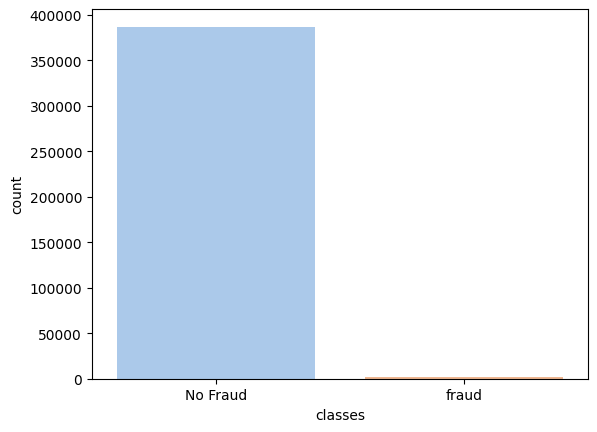

In [20]:
# Visualise to show level of class imbalance in Bank Credit Card Fraud Dataset
import seaborn as sns
label_class= df['is_fraud'].value_counts()
sns.barplot(x=['No Fraud','fraud',],y=label_class, palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Balance the dataset using NearMiss technique.
nm2 = NearMiss(
      sampling_strategy='auto',
      version=2)

# Apply the NearMiss technique on the dataset (X and y).
X_resampled, y_resampled = nm2.fit_resample(X, y)

In [ ]:
# Add a new column named 'label' to the DataFrame `X_resampled`
X_resampled['label'] = y_resampled

In [ ]:
# Check head using first five rows
X_resampled.head(5)

In [ ]:
# Save DataFrame to a CSV file
X_resampled.to_csv("file1.csv")

In [ ]:
# Initiate the spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('empirical-evaluation').getOrCreate()
# read the CSV file into a Spark DataFrame
df = spark.read.csv('file1.csv', header = True, inferSchema = True)
df.printSchema()
cols=df.columns

In [ ]:
# Visualise to check level of imbalance
import seaborn as sns
label_class=df.groupBy('label').count().toPandas()
sns.barplot(x=['Fraud','No Fraud',],y=label_class['count'], palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Check summary statistics for each column
df.describe().toPandas()

In [ ]:
# feature scaling and vector assembling
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Instantiate a 'VectorAssembler` object and transform
sel_cols = df.columns
assembler = VectorAssembler(inputCols = sel_cols,
                            outputCol = "features_vectorize")
data = assembler.transform(df)

In [ ]:
# Select distinct values from the "label" column, order them in ascending order,
# and then collect the values into a list.
label_list = data.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()

In [ ]:
# Quick inspection of the data using the first 5 rows
pd.DataFrame(data.take(5),columns=data.columns)

In [ ]:
# Split dataset into train and test
train, test = data.randomSplit([0.8, 0.2], seed = 12)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

In [ ]:
# Group by 'label' column and count number of occurences
# Convert to a Pandas DataFrame for easier manipulation.
train_label=train.groupBy('label').count().toPandas()
test_label=test.groupBy('label').count().toPandas()

In [ ]:
# extract the counts of each unique value in the 'label' column
# from both the train and test and combine in a single list.
items1=[i for i in train_label['count'].values]
items2=[i for i in test_label['count'].values]
items=items1+items2

In [ ]:
# Create a bar plot using seaborn.
classes=['train Fraud',"train NoFraud","test Fraud","test NoFraud"]
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=classes,y=items, palette="pastel")
plt.xlabel('classes')
plt.ylabel('count')
plt.show()

In [ ]:
# Initialise Logistic Regression model with specified hyperparameters
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol = 'features_vectorize',
                        labelCol = 'label', family="multinomial")

# Initialise Decision Tree model
dt = DecisionTreeClassifier(featuresCol = 'features_vectorize', labelCol = 'label')

# Initialise Random Forest model with 20 trees
rf = RandomForestClassifier(labelCol="label", featuresCol='features_vectorize', numTrees=20)

# Initialise Naive Bayes Multinomial model
nb = NaiveBayes(labelCol="label", featuresCol='features_vectorize', smoothing=1.0, modelType="multinomial")

# Store models in a dictionary for easier iteration
classifiers = {"Logistic Regression": lr, "Decision Tree": dt,
               "Random Forest": rf, "Naive Bayes Multinomial": nb}

# Define evaluation metrics to be computed for each model
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

print("\nModels Evaluation:")
print("{:-<24}".format(""))

# Iterate through each classifier
for idx, c in enumerate(classifiers):
  print(c)

	# Fit the model on the training data
  print(f'now running {c} model')
  model = classifiers[c].fit(train)

  # Use the trained model to make predictions on the test data
  predictions = model.transform(test)
  predictions.cache()

  # Evaluate the performance of the model using PySpark's MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
  for m in metrics:
    evaluator.setMetricName(m)
    metric = evaluator.evaluate(predictions)
    print("{name} = {value:.2f}".format(name=m, value=metric))

    # Build confusion matrix using Scikit-learn
    target_list = predictions.select("label").rdd.flatMap(lambda x: x).collect()
    pred_list = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
    label_num_list = predictions.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
    # print("\nClassification report using Sklearn:")
    # print(classification_report(target_list, pred_list, target_names=label_list))

    # Compute and visualize the confusion matrix using seaborn
    conf_matrix = confusion_matrix(target_list, pred_list)
    plt.figure(idx)
    plt.title("Confusion matrix - {model}".format(model=c))
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
	            annot_kws={"size": 7.5}, xticklabels=label_list, yticklabels=label_list)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()

# Display all the confusion matrix plots
plt.show()

In [ ]:


#X_resampled, y_resampled = tl.fit_resample(X, y)

#nm2 = NearMiss(
 #   sampling_strategy='auto',  # undersamples only the majority class
  #  version=2)
#X_resampled, y_resampled = nm2.fit_resample(X, y)

#rus = RandomUnderSampler(sampling_strategy='auto',  # samples only the majority class
 #   random_state=0,  # for reproducibility
  #  replacement=True # if it should resample with replacement)
#X_resampled, y_resampled = rus.fit_resample(X, y)

#ros = RandomOverSampler()
#X_resampled, y_resampled = ros.fit_resample(X, y)